In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
import statistics
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.layers.core import Dense, Activation, Dropout
import time  # helper libraries

from dataset_window import Dataset


def convertCash(cash):
	cash = cash.replace('.', '')
	cash = cash.replace(',', '.')
	return float(cash)

def clearNanMM(moving_average, price):
        moving_average[0] = price[0]
        moving_average[1] = (price[0] + price[1])/2
        moving_average[2] = (price[0] + price[1] + price[2])/3
        return moving_average;


def create_dataset(dataset, look_back=1):
	dataX, dataY = [], [] 
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), :]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])

	return np.array(dataX), np.array(dataY)

#Carregando os dados
data = pd.read_csv("Preços_semanais.csv")
data['DATA'] = pd.to_datetime(data.DATA, format='%d/%m/%y')
data.set_index('DATA', inplace=True)
index = data.index.values
# print(index)
# data['PREÇO'] = data['PREÇO'].apply(convertCash)
data['PREÇO_DOLAR'] = data['PREÇO_DOLAR'].apply(convertCash)

import talib as ta

data['MEDIA_MOVEL'] = ta.EMA(data['PREÇO'], timeperiod=4)
data['MEDIA_MOVEL'] = clearNanMM(data['MEDIA_MOVEL'], data['PREÇO'])

# data['MEDIA_MOVEL_DOLAR'] = ta.EMA(data['PREÇO_DOLAR'], timeperiod=4)
# data['MEDIA_MOVEL_DOLAR'] = clearNanMM(data['MEDIA_MOVEL_DOLAR'], data['PREÇO_DOLAR'])

print(index)

['2015-12-28T00:00:00.000000000' '2016-01-04T00:00:00.000000000'
 '2016-01-11T00:00:00.000000000' '2016-01-18T00:00:00.000000000'
 '2016-01-25T00:00:00.000000000' '2016-02-01T00:00:00.000000000'
 '2016-02-08T00:00:00.000000000' '2016-02-15T00:00:00.000000000'
 '2016-02-22T00:00:00.000000000' '2016-02-29T00:00:00.000000000'
 '2016-03-07T00:00:00.000000000' '2016-03-14T00:00:00.000000000'
 '2016-03-21T00:00:00.000000000' '2016-03-28T00:00:00.000000000'
 '2016-04-04T00:00:00.000000000' '2016-04-11T00:00:00.000000000'
 '2016-04-18T00:00:00.000000000' '2016-04-25T00:00:00.000000000'
 '2016-05-02T00:00:00.000000000' '2016-05-09T00:00:00.000000000'
 '2016-05-16T00:00:00.000000000' '2016-05-23T00:00:00.000000000'
 '2016-05-30T00:00:00.000000000' '2016-06-06T00:00:00.000000000'
 '2016-06-13T00:00:00.000000000' '2016-06-20T00:00:00.000000000'
 '2016-06-27T00:00:00.000000000' '2016-07-04T00:00:00.000000000'
 '2016-07-11T00:00:00.000000000' '2016-07-18T00:00:00.000000000'
 '2016-07-25T00:00:00.000

<ipython-input-1-5fb4ad5c8e07>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moving_average[0] = price[0]
<ipython-input-1-5fb4ad5c8e07>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moving_average[1] = (price[0] + price[1])/2
<ipython-input-1-5fb4ad5c8e07>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moving_average[2] = (price[0] + price[1] + price[2])/3


In [2]:
scaler_price = MinMaxScaler(feature_range=(0,1))
scaler_dollar = MinMaxScaler(feature_range=(0,1))
scaler_media_movel = MinMaxScaler(feature_range=(0,1))
data['PREÇO'] = scaler_price.fit_transform(data['PREÇO'].to_numpy().reshape(-1, 1))
data['PREÇO_DOLAR'] = scaler_dollar.fit_transform(data['PREÇO_DOLAR'].to_numpy().reshape(-1, 1))
data['MEDIA_MOVEL'] = scaler_dollar.fit_transform(data['MEDIA_MOVEL'].to_numpy().reshape(-1, 1))
# data['MEDIA_MOVEL_DOLAR'] = scaler_dollar.fit_transform(data['MEDIA_MOVEL_DOLAR'].to_numpy().reshape(-1, 1))

In [3]:
window = 4
shape_dataset = 154
epochs = 1000

x,y = create_dataset(data.values, window)
print(x.shape)

(205, 4, 3)


In [4]:
train_x, test_x = x[0:shape_dataset, :], x[shape_dataset:, :]

train_y, test_y = y[0:shape_dataset], y[shape_dataset:]

print(test_y.shape)

(51,)


In [5]:
model = Sequential()
model.add(LSTM(25, input_shape=(4, 3)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(train_x, train_y, epochs=epochs, verbose=1)

trainPredict = model.predict(train_x)
testPredict = model.predict(test_x)

Epoch 1/1000
5/5 [==============================] - 2s 5ms/step - loss: 0.0678
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0446
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0243
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0207
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0164
Epoch 6/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.0148
Epoch 7/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.0170
Epoch 8/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0172
Epoch 9/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.0142
Epoch 10/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.0155
Epoch 11/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0117
Epoch 12/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0137
Epoch 13/1000
5/5 [=============================

In [6]:
print(test_x)
trainPredict = model.predict(train_x)
testPredict = model.predict(test_x)

[[[0.74683544 0.71069565 0.5962025 ]
  [0.62025316 0.69095652 0.62332073]
  [0.56962025 0.54678261 0.61739323]
  [0.64556962 0.54313043 0.64713438]]

 [[0.62025316 0.69095652 0.62332073]
  [0.56962025 0.54678261 0.61739323]
  [0.64556962 0.54313043 0.64713438]
  [0.62025316 0.57826087 0.65387985]]

 [[0.56962025 0.54678261 0.61739323]
  [0.64556962 0.54313043 0.64713438]
  [0.62025316 0.57826087 0.65387985]
  [0.62025316 0.59486957 0.65792714]]

 [[0.64556962 0.54313043 0.64713438]
  [0.62025316 0.57826087 0.65387985]
  [0.62025316 0.59486957 0.65792714]
  [0.56962025 0.49826087 0.63815708]]

 [[0.62025316 0.57826087 0.65387985]
  [0.62025316 0.59486957 0.65792714]
  [0.56962025 0.49826087 0.63815708]
  [0.56962025 0.55869565 0.62629504]]

 [[0.62025316 0.59486957 0.65792714]
  [0.56962025 0.49826087 0.63815708]
  [0.56962025 0.55869565 0.62629504]
  [0.44303797 0.534      0.56368175]]

 [[0.56962025 0.49826087 0.63815708]
  [0.56962025 0.55869565 0.62629504]
  [0.44303797 0.534      0

In [7]:
trainPredict = scaler_price.inverse_transform(trainPredict)
train_y = scaler_price.inverse_transform([train_y])

testPredict = scaler_price.inverse_transform(testPredict)
test_y = scaler_price.inverse_transform([test_y])



arr1 = index[158:];

df = pd.DataFrame(testPredict, columns=['preco'])
df['data'] = arr1

# df.set_index('data', inplace=True)

# print(df)

# print(df.to_json())

# print(testPredict)



In [8]:
#calculate mean absolute error
mape_train = mean_absolute_percentage_error(train_y[0], trainPredict)
print('Train Score: %.2f MAPE' % (mape_train))
mape_test = mean_absolute_percentage_error(test_y[0], testPredict)
print('Test Score: %.2f MAPE' % (mape_test))
print('\n -----------------------------------------\n')
#calculate mean absolute error
mae_train = mean_absolute_error(train_y[0], trainPredict)
print('Train Score: %.2f MAE' % (mae_train))
mae_test = mean_absolute_error(test_y[0], testPredict)
print('Test Score: %.2f MAE' %(mae_test))
print('\n -----------------------------------------\n')
# calculate root mean squared error
rmse_train = math.sqrt(mean_squared_error(train_y[0], trainPredict))
print('Train Score: %.2f RMSE' % (rmse_train))
rmse_test = math.sqrt(mean_squared_error(test_y[0], testPredict))
print('Test Score: %.2f RMSE' % (rmse_test))

Train Score: 0.17 MAPE
Test Score: 0.15 MAPE

 -----------------------------------------

Train Score: 4.10 MAE
Test Score: 6.32 MAE

 -----------------------------------------

Train Score: 5.52 RMSE
Test Score: 8.78 RMSE


In [9]:
def sanitize_date(date):
    return date.month

def price_of_month(group):
    return group.iloc[-1,:]
    
prices = pd.DataFrame({
    'price': test_y.reshape(-1),
    'date': index[158:]
})

prices['month'] = prices.date.apply(sanitize_date)

prices_groupped = prices.groupby('month')

prices_by_month = prices_groupped.apply(price_of_month)

prices_by_month = prices_by_month.set_index('month')

price_json = prices_by_month.to_json(orient='index', date_format='iso', indent=4)


with open('price.json', 'w') as price_file:
    price_file.write(price_json)


In [10]:
import talib as ta

mma = ta.EMA(testPredict.reshape(-1).astype('double'), timeperiod = 4)

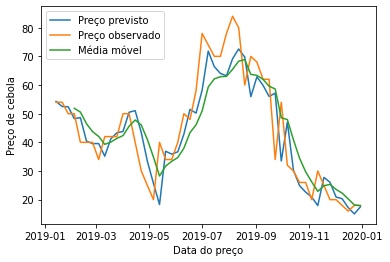

In [11]:
plt.plot(index[158:], testPredict, label='Preço previsto')
plt.plot(index[158:], test_y.reshape(-1, 1), label='Preço observado')
plt.plot(index[158:], mma, label="Média móvel")
plt.ylabel('Preço de cebola')
plt.xlabel('Data do preço')
plt.legend()
plt.show()